# Bayesian model

A bayesian gaussian mixture model is still based on Gaussian components, but introduces priors to help with overfitting and automatic model complexity selection.

Pros:

Handles uncertainty in model parameters.

Penalizes overly complex models via priors (Dirichlet Process-style).



## Assignment A
ML for isothermal/non-isothermal H2-Ni interactions -> there is no rotational velocity

In [2]:
import sys
print(sys.executable)


c:\Users\jespe\miniconda3\python.exe


In [1]:
import os
import numpy as np
from scipy.special import erf, erfinv
#from math import erf
from numpy.linalg import norm
from mlmm import VelocityData, plot_learn_curve, n_fold_cv, fileinfo,VelocityDataOmegaData, OmegaData

import matplotlib.pyplot as plt

from datetime import date
today = date.today().strftime("%b-%d-%Y")
import periodictable

import sys
from mlmm import func_postprocess
import time



er_type = 'MAE'

system_6D = True # Assignment A uses 6D data since we are using only the translational velocity data
system_10D = False
system_omega = False # Set to false, since we are not using angular velocity data in this assignment
wall_temp = 300
Liao_Transfer_Function = True

kB,conv_v,conv_omega,av_num = 1.38064852e-23,1.0e2,1.0e12,6.022e23




x_data = [
          ]
y_data = [
          ]

x_omega = []
y_omega = []

x_MD = []
y_MD = []

# Path to the data files for Task 1
# Materials_for_ML_assignment\H2_IsoThermalWalls_Sw_0\H2_Vel_MD_Sw_0_B300_Th_300.txt  
# Materials_for_ML_assignment\H2_NonIsoThermalWalls_Sw_0\H2_Vel_MD_Sw_0_T500_Tb_300.txt  
# Materials_for_ML_assignment\H2_NonIsoThermalWalls_Sw_0\H2_Vel_MD_Sw_0_B300_Th_500.txt

path_to_data = 'Data_H2_assignment_bayesian_A'
path_save_data='./'+path_to_data
#path_to_data = 'Shahin/test_data/'



for file in os.listdir(path_to_data):

    if file.endswith(".txt") and "MD" in file:
        x_MD.append(os.path.join(path_to_data,file))
        y_MD.append('')

    if file.endswith(".txt") and "omega" in file:
        x_omega.append(os.path.join(path_to_data,file))
        y_omega.append('')
print("Data files found:",x_MD)


######################################################################################
#------------------------------- Getting translational velocity data
####--------------------------------------------------------------------------------------------------
for x_data_file,y_data_file in zip(x_MD,y_MD):
    

    conf = VelocityData(x_data_file, frames=None)#[0,30000])
    conf.getRep(rep='vxvyvz',nuc=None) #rep options: vxvyvz, vel2norm, vx2,vy2,vz2,vx,vy,vz
    file_name=x_data_file.replace('.','/')
    file_name=file_name.split('/')
    set_name = file_name[1]
    X = conf.X
    y = conf.y
    if "He" in path_to_data:
        mass = getattr(periodictable,'He').mass
        gas_name = 'He'
    elif "Ar" in path_to_data:
        mass = getattr(periodictable,'Ar').mass
        gas_name = 'Ar'
    elif "H2" in path_to_data:
        mass =2* getattr(periodictable,'H').mass
        gas_name = 'H2'
        l_b=0.741e-10
        mass_kg = mass * 0.001 / av_num
        I=(mass_kg/4)*l_b**2
    elif "N2" in path_to_data:
        mass =2* getattr(periodictable,'N').mass
        gas_name = 'N2'
        l_b=1.097e-10
        mass_kg = mass * 0.001 / av_num
        I=(mass_kg/4)*l_b**2
    else:
        print ("Unable to identify impinging atom type...")
        ele = str(input("Enter the impinging atom symbol : "))
        mass = getattr(periodictable,ele).mass
        v_mp = np.sqrt(2 * kB * wall_temp / mass_kg)
        omega_mp = np.sqrt(2 * kB * wall_temp / I)
    print ('Atomic mass for {} molecule is {:1.4f} \n'.format(gas_name,mass))
    n_MD = X.shape[0]
    print('Number of MD tr velocity data points: {} \n'.format(n_MD))
    # Implementing Liao Transfer function on perpendicular velocity component
    v_TF,T_in,T_out,theta_in,theta_out=func_postprocess.liao_transform(X,mass,'y')
    v_RTF=func_postprocess.liao_R_transform(v_TF,theta_in,theta_out,'y')
    MAC_x,MAC_y,MAC_z,EAC_x,EAC_y,EAC_z,EAC_tr=func_postprocess.compute_AC_correlation_method(X,'Ar','y') #
    AC_MD_tr = [MAC_x,MAC_y,MAC_z,EAC_x,EAC_y,EAC_z,EAC_tr]


######################################################################################
#------------------------------- Getting angular velocity data
####--------------------------------------------------------------------------------------------------
if system_omega:
    for x_data_file2,y_data_file2 in zip(x_omega,y_omega):
        #conf2 = OmegaData(x_data_file2, frames=frames)#[0,30000])
        conf2 = OmegaData(x_data_file2, frames=None)#[0,30000])
        conf2.getRep(rep='omega1omega2',nuc=None) #rep options: vxvyvz, vel2norm, vx2,vy2,vz2,vx,vy,vz
        omega_file_name = x_data_file2.replace('.','/')
        omega_file_name = omega_file_name.split('/')
        omega_name = omega_file_name[1]
        print(omega_name)
        X2 = conf2.X2
        y2 = conf2.y2
        print('Number of MD rot velocity data points: {} \n'.format(X2.shape[0]))
        X2_TF=np.copy(X2)
        Y2_TF=np.copy(y2)
        omega_TF=np.vstack((X2_TF,-X2_TF))
        y2_TF=np.hstack((Y2_TF,-Y2_TF))   

######################################################################################
#------------------------------- Implementing GM model on 10D data
####--------------------------------------------------------------------------------------------------                   

if system_10D:
    vel_tr = np.copy(X)
    vel_tr[:,1]=np.abs(vel_tr[:,1])
    vel_tr[:,4]=np.abs(vel_tr[:,4])
    data_for_AC_MD = np.concatenate((vel_tr,X2),axis=1)

    
    if Liao_Transfer_Function:
        #omega_bond = np.copy(X2)
        v_tr=np.copy(v_TF[:n_MD,:])
        v_omega = np.copy(X2)
        v_mp = np.sqrt(2 * kB * wall_temp / mass_kg)
        omega_mp = np.sqrt(2 * kB * wall_temp / I)
        #--- Normalazing the translational and rotational velocities
        data_train_10D = np.concatenate((v_tr*conv_v/v_mp,X2*conv_omega/omega_mp),axis=1)

        print('The total number of training points is: {} \n'.format(data_train_10D.shape[0]))
        
    else:
        data_train_10D = data_for_AC_MD
        print('The total number of training points is: {} \n'.format(data_train_10D.shape[0]))

Data files found: ['Data_H2_assignment_bayesian_A\\H2_Vel_MD_Sw_0_B300_Th_300.txt']
Generating Representation


0% [####                          ] 100% | ETA: 00:00:00

Not a float


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Atomic mass for H2 molecule is 2.0159 

Number of MD tr velocity data points: 123351 



## Preprocessing

In [3]:
# 1 Bayesian model - preprocessing
import pandas as pd

X_df = pd.DataFrame(X, columns=['vx_in', 'vy_in', 'vz_in', 'vx_out', 'vy_out', 'vz_out'], copy=True)

X_in = np.copy(X[:,:3])
X_out = np.copy(X[:,3:])

#X_df = X_df[:8000] # Take small percentage of data for testing
X_df

# TODO: something is done with the y data to convert it to gaussian, and later back, because it is now Rayleigh distributed -> todo: look in paper what is being done

,vx_in,vy_in,vz_in,vx_out,vy_out,vz_out
0,-19.063490,-2.721230,-1.898435,-10.097920,14.351700,-10.128445
1,-14.207510,-12.694940,8.064925,19.730700,4.442650,-4.679550
2,10.970280,-15.174750,-7.416400,-4.919135,10.238755,10.174040
3,12.163100,-18.675745,10.151765,-18.584276,21.490740,-7.930920
4,-19.325736,-20.558550,-14.049560,-10.264800,11.402860,-10.448760
...,...,...,...,...,...,...
123346,15.507750,-18.799500,-8.707695,-5.300895,16.190505,-1.412000
123347,3.569445,-7.417320,-6.976990,5.608970,20.436850,-4.742325
123348,-8.581765,-3.614315,-9.214725,-9.251465,0.545300,-18.953625
123349,9.463104,-23.529725,0.392580,6.188955,11.167950,-15.990180


## Visualizing the data

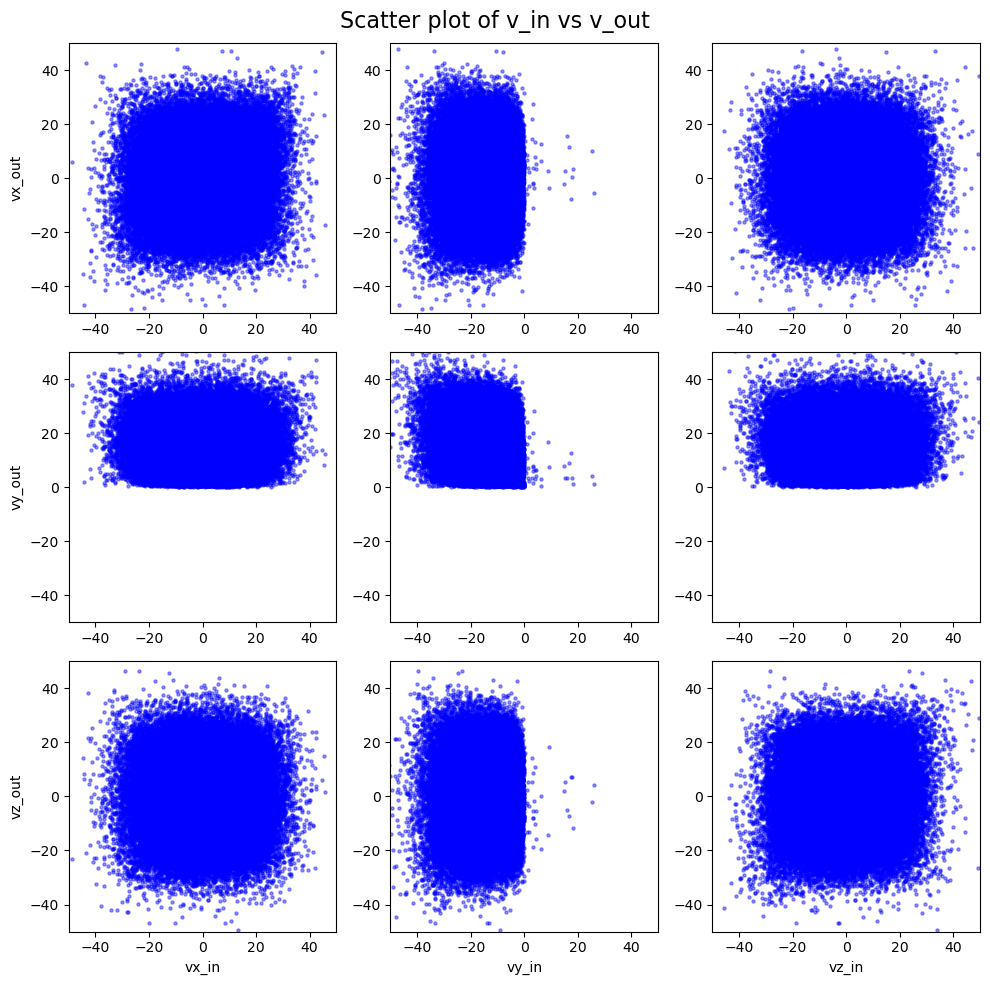

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
labels = ["x", "y", "z"]
for row in range(3):
    ax[row, 0].set_ylabel(f'v{labels[row]}_out')  
    ax[2, row].set_xlabel(f'v{labels[row]}_in')
    for column in range(3):
        v_in = X_df.iloc[:, column]  # Correctly select v_in for each column
        v_out = X_df.iloc[:, row + 3]  # Correctly select v_out for each row
        ax[row, column].scatter(v_in, v_out, c='blue', s=5, alpha=0.4, label='Data points')
        ax[row,column].set_xlim(-50,50)
        ax[row,column].set_ylim(-50,50)
fig.suptitle('Scatter plot of v_in vs v_out', fontsize=16)
fig.tight_layout()
plt.show()


## Train both models

In [5]:
from sklearn.mixture import BayesianGaussianMixture
from sklearn.mixture import GaussianMixture

# N_G as from the literature. TODO: plot N_G vs accomodation coefficient, as is done in the literature
N_G = 600

# Create a function to make and fit a GMM model
def initialize_gmm(X, n_components):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', tol=0.001)
    gmm.fit(X)
    return gmm

# Create a function to make and fit a Bayesian GMM model
def initialize_bayesian_gmm(X, n_components):
    bayesian_gmm = BayesianGaussianMixture(n_components=n_components)
    bayesian_gmm.fit(X)
    return bayesian_gmm

# TODO: lookup how the accomodation coefficient is calculated in the paper and create a for loop to calculate it for all possible models (N_G =1 to 1000)


## Visualize the PDF of both models

In [6]:
gmm_model = initialize_gmm(X_df, N_G)
bayesian_model = initialize_bayesian_gmm(X_df, N_G)

c:\Users\jespe\miniconda3\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


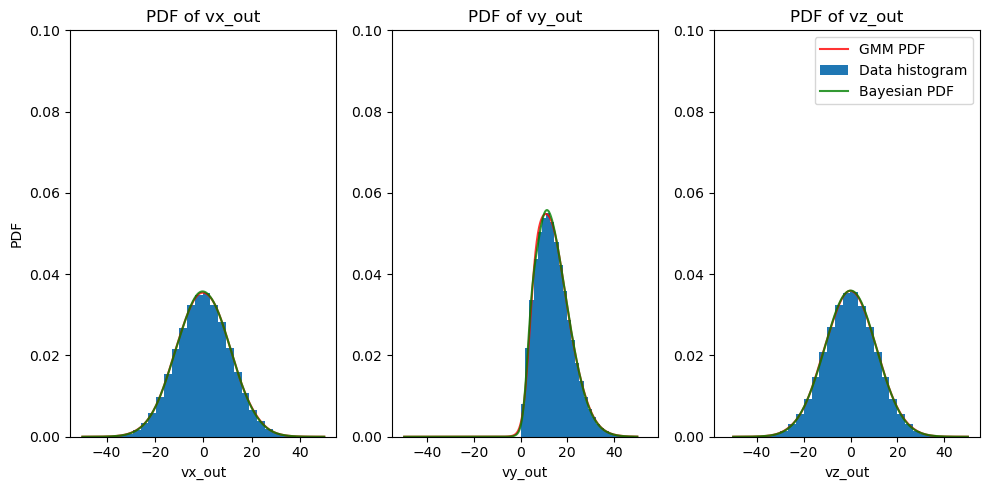

In [7]:
from numpy.linalg import norm as linalg_norm
from scipy.stats import norm


# Extract marginal pdf for each feature from the GMM model
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

labels = ["vx_out", "vy_out", "vz_out"]
feature_index = [3, 4, 5]
xlim = np.linspace(-50, 50, 1000)

for i in range(3):
    pdf_gmm = np.zeros_like(xlim)
    pdf_bayesian = np.zeros_like(xlim)

    for j in range(N_G):
        # Extract the mean, covariance, and weight for each gmm component
        mean_gmm = gmm_model.means_[j, feature_index[i]]
        cov_gmm = gmm_model.covariances_[j, feature_index[i], feature_index[i]]
        weight_gmm = gmm_model.weights_[j]
        pdf_gmm += weight_gmm * norm.pdf(xlim, loc=mean_gmm, scale=np.sqrt(cov_gmm))
        
        # Extract the mean, covariance, and weight for each bayesian component
        mean_bayesian = bayesian_model.means_[j, feature_index[i]]
        cov_bayesian = bayesian_model.covariances_[j, feature_index[i], feature_index[i]]
        weight_bayesian = bayesian_model.weights_[j]
        pdf_bayesian += weight_bayesian * norm.pdf(xlim, loc=mean_bayesian, scale=np.sqrt(cov_bayesian))

        # Compute histogram
        

    # Visualize the pdf of the gmm as a line plot
    ax[i].plot(xlim, pdf_gmm, c='red', alpha=0.8, label='GMM PDF')
    ax[i].hist(X_df.iloc[:,feature_index[i]], bins=30, density=True, label='Data histogram')
    
    # Visualize the pdf of the bayesian model as a line plot
    ax[i].plot(xlim, pdf_bayesian, c='green', alpha=0.8, label='Bayesian PDF')
    ax[i].set_ylim([0, 0.10])
    ax[i].set_xlabel(f'{labels[i]}')
    ax[i].set_title(f'PDF of {labels[i]}')
    
    
ax[0].set_ylabel("PDF")
ax[2].legend(loc=1)
fig.tight_layout()
plt.show()


## Seek out the best models based on AC
assume that we are still using a 6D model, so no Liao transfer function

c:\Users\jespe\miniconda3\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Number of components: 100, GMM AC diff: [np.float64(-0.32574400938969555), np.float64(-77.17374352404465), np.float64(-0.6269787412620662), np.float64(-1.8490766579319022), np.float64(-205.1264412480029), np.float64(-1.5711590054892044), np.float64(-4.676177594024695)], Bayesian GMM AC diff: [np.float64(-0.3872061817447497), np.float64(-76.02732893201853), np.float64(-0.37939779741065194), np.float64(-0.7970190495709791), np.float64(-210.50230309620846), np.float64(-2.6726463308400166), np.float64(-4.246722846622552)]


c:\Users\jespe\miniconda3\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Number of components: 200, GMM AC diff: [np.float64(0.16944398780339895), np.float64(-76.0750184220569), np.float64(0.7879727986778204), np.float64(-1.113033006241447), np.float64(-201.8999583628764), np.float64(-0.7724600210724426), np.float64(-3.1621885748148775)], Bayesian GMM AC diff: [np.float64(-0.10710819794151559), np.float64(-76.42796319325704), np.float64(0.41163801908913533), np.float64(-0.4242718448097951), np.float64(-209.2826250198323), np.float64(-1.688748822031319), np.float64(-3.203633365383479)]


c:\Users\jespe\miniconda3\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Number of components: 300, GMM AC diff: [np.float64(0.935322387955711), np.float64(-76.9675610292076), np.float64(0.37538663081617746), np.float64(-0.2827809189130911), np.float64(-209.10968694555794), np.float64(-0.4272771144227739), np.float64(-1.1733572398060672)], Bayesian GMM AC diff: [np.float64(0.4065503605446026), np.float64(-76.77794553276186), np.float64(-0.09169270748067189), np.float64(-0.8123628453339318), np.float64(-211.2572127720128), np.float64(-0.05564884185160968), np.float64(-1.0061256413266244)]


c:\Users\jespe\miniconda3\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Number of components: 400, GMM AC diff: [np.float64(-0.3282286945926304), np.float64(-77.01933457192008), np.float64(-0.0017805286354917443), np.float64(-0.49713394260465316), np.float64(-211.28149578518816), np.float64(-0.9417793920010268), np.float64(-0.732048946581737)], Bayesian GMM AC diff: [np.float64(0.09235999428798693), np.float64(-77.87630630221621), np.float64(-0.006787641302235201), np.float64(-0.34269005575614053), np.float64(-211.1790309831384), np.float64(0.6885638524739309), np.float64(0.6809398429561977)]


c:\Users\jespe\miniconda3\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Number of components: 500, GMM AC diff: [np.float64(-0.3595763521267937), np.float64(-76.7021133007453), np.float64(-0.14696329340143996), np.float64(-1.1335028994608476), np.float64(-209.338446997574), np.float64(-1.3567240350314385), np.float64(-1.6571950248825504)], Bayesian GMM AC diff: [np.float64(-0.42292590903991917), np.float64(-77.76744419491561), np.float64(-0.6377075923196224), np.float64(-0.5216380018914751), np.float64(-216.8506079659009), np.float64(-0.4699670096037274), np.float64(-1.7102776395110246)]


c:\Users\jespe\miniconda3\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Number of components: 600, GMM AC diff: [np.float64(0.0030352234074250643), np.float64(-75.99157641687533), np.float64(0.08548338098134242), np.float64(-0.47144246370554144), np.float64(-205.5420551997807), np.float64(-0.037645999374346026), np.float64(0.0033375332863410717)], Bayesian GMM AC diff: [np.float64(-0.003387320574834451), np.float64(-77.2635340062278), np.float64(-0.8762378936963552), np.float64(-1.277771738387342), np.float64(-211.60509481945633), np.float64(-0.06311936172039202), np.float64(-1.5493981599657698)]


c:\Users\jespe\miniconda3\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Number of components: 700, GMM AC diff: [np.float64(-0.774897151573775), np.float64(-76.23145963433005), np.float64(-0.4629604700356219), np.float64(0.7627654218831459), np.float64(-208.2140788723155), np.float64(0.08534011182043728), np.float64(0.06543384649268907)], Bayesian GMM AC diff: [np.float64(-0.6211551738566589), np.float64(-77.3680122725218), np.float64(0.29900367372823705), np.float64(-0.2164300412521485), np.float64(-216.48473721608693), np.float64(-0.6829302049020568), np.float64(-1.8869237703166393)]


c:\Users\jespe\miniconda3\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Number of components: 800, GMM AC diff: [np.float64(0.16325157229455414), np.float64(-77.63328816786866), np.float64(-0.13625781311467244), np.float64(-0.7401731423770548), np.float64(-215.2969512523263), np.float64(-0.8566747889319523), np.float64(-1.8862516409451162)], Bayesian GMM AC diff: [np.float64(-0.06399845905735926), np.float64(-76.4519106864607), np.float64(0.6467524627575214), np.float64(-1.0038431563653627), np.float64(-210.2591826242255), np.float64(-0.31463891531437826), np.float64(-3.2954393722849322)]


c:\Users\jespe\miniconda3\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Number of components: 900, GMM AC diff: [np.float64(0.8242625462309061), np.float64(-76.33153063448233), np.float64(-0.2986516810364943), np.float64(-0.840931908137242), np.float64(-202.0224912262428), np.float64(-0.01974301765448265), np.float64(-1.0036690209205272)], Bayesian GMM AC diff: [np.float64(-0.20174690061776643), np.float64(-77.29049261450189), np.float64(-0.1767688811305945), np.float64(0.0884010258593334), np.float64(-214.5016682335088), np.float64(-0.24863675621526604), np.float64(-2.5437669819077335)]


ValueError: x and y must have same first dimension, but have shapes (50,) and (9, 7)

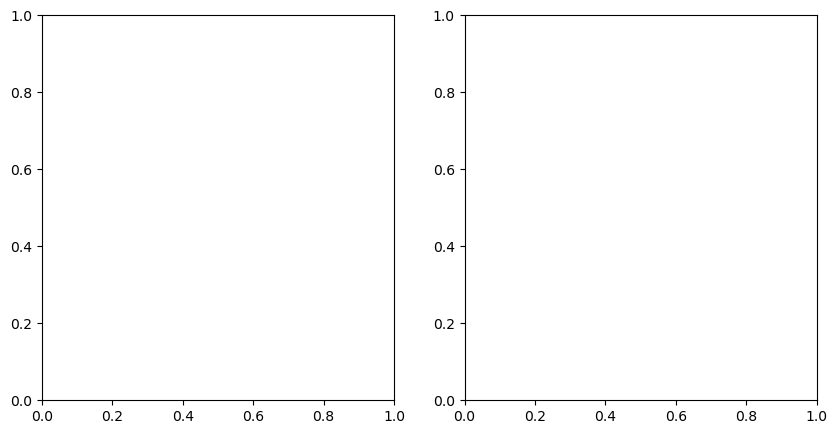

In [ ]:
AC = ['MAC_x','MAC_y','MAC_z','EAC_x','EAC_y','EAC_z','EAC_tr']

def calculate_accomodation_coefficient(model, X_train, Liao_Transfer_Function=True, AC_MD_tr = AC_MD_tr):
    """
    Calculate the accommodation coefficient for a given model and training data.
    @param model: The GMM or Bayesian GMM model.
    @param X_train: The training data.
    @return: The difference in accommodation coefficient with the MD AC.
    """
    # Make predictions using the model
    pred = model.sample(X_train.shape[0])
    v_pred=np.copy(pred[0])
    
    if Liao_Transfer_Function:
        v_RTF_pred=func_postprocess.liao_R_transform(v_pred,theta_in,theta_out,'y') # using RTF on predicted results
        MAC_x_ML,MAC_y_ML,MAC_z_ML,EAC_x_ML,EAC_y_ML,EAC_z_ML,\
                        EAC_tr_ML=func_postprocess.compute_AC_correlation_method(v_RTF_pred,'Ar','y')
        AC_ML = [MAC_x_ML,MAC_y_ML,MAC_z_ML,EAC_x_ML,EAC_y_ML,EAC_z_ML,\
                        EAC_tr_ML]
        
        AC_diff_ML=func_postprocess.ac_diff(AC_MD_tr,AC_ML)
        
    return AC_diff_ML
    
# Initialize an empty list to store the accommodation coefficients
AC_diff_list_gmm = []
AC_diff_list_bayesian = []


for i in range(100, 1000, 100):
    # Create a GMM model with i components
    gmm_model = initialize_gmm(X_df, i)
    bayesian_model = initialize_bayesian_gmm(X_df, i)

    # Calculate the accommodation coefficient for the GMM model
    AC_diff_gmm = calculate_accomodation_coefficient(gmm_model, X_df, Liao_Transfer_Function)
    AC_diff_list_gmm.append(AC_diff_gmm)
    
    # Calculate the accommodation coefficient for the Bayesian GMM model
    AC_diff_bayesian = calculate_accomodation_coefficient(bayesian_model, X_df, Liao_Transfer_Function)
    AC_diff_list_bayesian.append(AC_diff_bayesian)
    
    print(f"Number of components: {i}, GMM AC diff: {AC_diff_gmm}, Bayesian GMM AC diff: {AC_diff_bayesian}")     
    

    

(-5.0, 1.0)

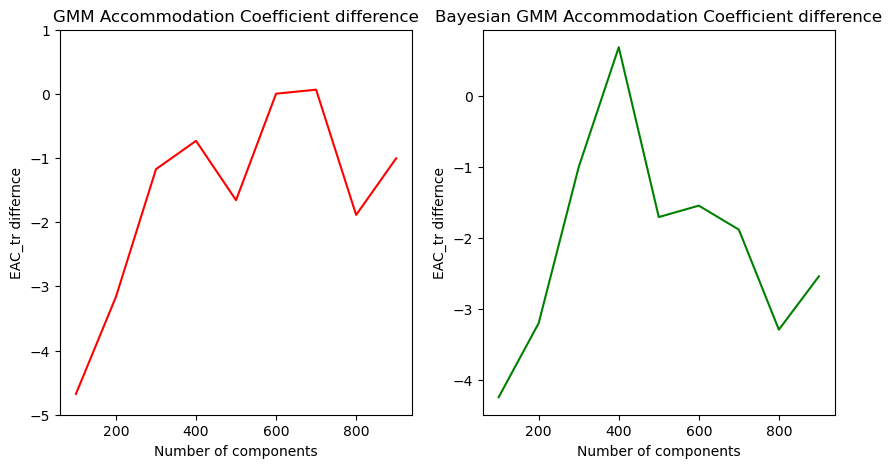

In [ ]:
# Plot the accommodation coefficients
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Convert lists to arrays
AC_diff_array_gmm = np.array(AC_diff_list_gmm)
AC_diff_array_bayesian = np.array(AC_diff_list_bayesian)

# Plot the accommodation coefficients for GMM
ax[0].plot(range(100, 1000, 100), AC_diff_array_gmm[:, 6], c='red', label='GMM AC diff')
ax[1].plot(range(100, 1000, 100), AC_diff_array_bayesian[:, 6], c='green', label='Bayesian GMM AC diff') 
ax[0].set_xlabel('Number of components')
ax[1].set_xlabel('Number of components')
ax[0].set_ylabel('EAC_tr differnce')
ax[1].set_ylabel('EAC_tr differnce')
ax[0].set_title('GMM Accommodation Coefficient difference')
ax[1].set_title('Bayesian GMM Accommodation Coefficient difference')
ax[0].set_ylim([-5, 1])
ax[1].set_ylim([-5, 1])


It seems that for the bayesian model we should take a lower N_G; namely N_G = 400

## Sample from the models to recreate the scatterplots v_in vs. v_out